### 70. 単語ベクトルの和による特徴量

データを読み込んで単語に分割する

In [1]:
import re
import spacy

In [2]:
nlp = spacy.load('en')
categories = ['b', 't', 'e', 'm']
category_names = ['business', 'science and technology', 'entertainment', 'health']

In [3]:
def tokenize(x):
    x = re.sub(r'\s+', ' ', x)
    x = nlp.make_doc(x)
    x = [d.text for d in x]
    return x

def read_feature_dataset(filename):
    with open(filename) as f:
        dataset = f.read().splitlines()
    dataset = [line.split('\t') for line in dataset]
    dataset_t = [categories.index(line[0]) for line in dataset]
    dataset_x = [tokenize(line[1]) for line in dataset]
    return dataset_x, dataset_t

In [4]:
train_x, train_t = read_feature_dataset('data/train.txt')
valid_x, valid_t = read_feature_dataset('data/valid.txt')
test_x, test_t = read_feature_dataset('data/test.txt')

特徴ベクトルに変換する

In [5]:
# ! pip install torch

In [6]:
import torch
from gensim.models import KeyedVectors

/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [7]:
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [8]:
def sent_to_vector(sent):
    lst = [torch.tensor(model[token]) for token in sent if token in model]
    return sum(lst) / len(lst)

def dataset_to_vector(dataset):
    return torch.stack([sent_to_vector(x) for x in dataset])

In [9]:
train_v = dataset_to_vector(train_x)
valid_v = dataset_to_vector(valid_x)
test_v = dataset_to_vector(test_x)

In [10]:
train_v[0]

tensor([ 9.0576e-02,  5.4932e-02, -7.7393e-02,  1.1810e-01, -3.8849e-02,
        -2.6074e-01, -6.4484e-02,  3.2715e-02,  1.1792e-01, -3.4363e-02,
        -1.5137e-02, -1.7090e-02,  7.2632e-02,  1.0742e-02,  1.1194e-01,
         5.8945e-02,  1.6275e-01,  1.5393e-01,  7.0496e-02, -1.5210e-01,
         2.8320e-02,  1.1719e-02,  1.9702e-01, -1.5610e-02, -2.3438e-02,
         1.8921e-02,  2.8687e-02, -2.3438e-02,  2.3315e-02, -5.7480e-02,
         2.1973e-03, -1.0449e-01, -9.7534e-02, -1.3694e-01,  1.6144e-01,
        -2.6062e-02,  3.1250e-02,  1.9482e-01, -1.0788e-01,  7.2571e-02,
        -1.3916e-02,  1.1121e-01,  7.0801e-03, -4.1016e-02, -1.9580e-01,
         1.7334e-02,  1.0986e-02, -6.9485e-03,  9.2773e-02,  7.2205e-02,
         6.8298e-02, -5.3589e-02, -1.7447e-01,  1.0245e-01, -8.6426e-02,
        -9.0942e-03, -1.7212e-01, -1.3789e-01, -1.0355e-01,  1.9226e-02,
         1.0620e-02,  9.7626e-02, -5.1147e-02,  1.1371e-01,  3.5156e-02,
        -4.8523e-03, -7.1960e-02,  1.1841e-01, -1.0

pickleにして保存

In [11]:
import pickle

In [12]:
train_t = torch.tensor(train_t).long()
valid_t = torch.tensor(valid_t).long()
test_t = torch.tensor(test_t).long()

In [13]:
with open('data/train.feature.pickle', 'wb') as f:
    pickle.dump(train_v, f)
with open('data/train.label.pickle', 'wb') as f:
    pickle.dump(train_t, f)
    
with open('data/valid.feature.pickle', 'wb') as f:
    pickle.dump(valid_v, f)
with open('data/valid.label.pickle', 'wb') as f:
    pickle.dump(valid_t, f)
    
with open('data/test.feature.pickle', 'wb') as f:
    pickle.dump(test_v, f)
with open('data/test.label.pickle', 'wb') as f:
    pickle.dump(test_t, f)

### 71. 単層ニューラルネットワークによる予測

出題意図としては，単なる行列にsoftmaxかけたり，後々backwardしたりするというものなのかもしれませんが，ここではnn.Moduleを継承するクラスを作っていきます．

In [14]:
import torch.nn as nn

In [15]:
class Perceptron(nn.Module):
    def __init__(self, v_size, c_size):
        super().__init__()
        self.fc = nn.Linear(v_size, c_size, bias = False)
        nn.init.xavier_normal_(self.fc.weight)
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [16]:
model = Perceptron(300, 4)

In [17]:
x = model(train_v[0])
x = torch.softmax(x, dim=-1)
x

tensor([0.2618, 0.2583, 0.2225, 0.2575], grad_fn=<SoftmaxBackward>)

In [18]:
x = model(train_v[:4])
x = torch.softmax(x, dim=-1)
x

tensor([[0.2618, 0.2583, 0.2225, 0.2575],
        [0.2467, 0.2446, 0.2424, 0.2663],
        [0.2292, 0.2399, 0.2579, 0.2731],
        [0.2508, 0.2765, 0.2058, 0.2669]], grad_fn=<SoftmaxBackward>)

### 72. 損失と勾配の計算

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
y = model(train_v[:1])
t = train_t[:1]
loss = criterion(y, t)
model.zero_grad()
loss.backward()
print('損失 :', loss.item())
print('勾配')
print(model.fc.weight.grad)

損失 : 1.356873631477356
勾配
tensor([[ 0.0237,  0.0144, -0.0203,  ...,  0.0310,  0.0318, -0.0046],
        [ 0.0234,  0.0142, -0.0200,  ...,  0.0306,  0.0313, -0.0045],
        [ 0.0202,  0.0122, -0.0172,  ...,  0.0264,  0.0270, -0.0039],
        [-0.0673, -0.0408,  0.0575,  ..., -0.0881, -0.0901,  0.0131]])


In [21]:
model.zero_grad()
model.fc.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [22]:
y = model(train_v[:4])
t = train_t[:4]
loss = criterion(y, t)
model.zero_grad()
loss.backward()
print('損失 :', loss.item())
print('勾配')
print(model.fc.weight.grad)

損失 : 1.3159091472625732
勾配
tensor([[ 0.0049,  0.0016, -0.0112,  ...,  0.0094,  0.0157, -0.0018],
        [-0.0006,  0.0035, -0.0081,  ...,  0.0080,  0.0114, -0.0010],
        [ 0.0032,  0.0009, -0.0117,  ...,  0.0080,  0.0142, -0.0017],
        [-0.0074, -0.0061,  0.0310,  ..., -0.0254, -0.0412,  0.0045]])


### 73. 確率的勾配降下法による学習

確率的勾配降下なので，データセットをシャッフルして少しずつ取り出すようにします

データを持ってるのがDataset

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, t):
        self.x = x
        self.t = t
        self.size = len(x)
    
    def __len__(self):
        return self.size
            
    def __getitem__(self, index):
        return {
            'x':self.x[index],
            't':self.t[index]}

データセットをバッチに分割してバッチのインデックスを返すのがSampler

In [24]:
class Sampler(torch.utils.data.Sampler):
    def __init__(self, dataset, width, shuffle=False):
        self.dataset = dataset
        self.width = width
        self.shuffle = shuffle
        if not shuffle:
            self.indices = torch.arange(len(dataset))
    
    def __iter__(self):
        if self.shuffle:
            self.indices = torch.randperm(len(self.dataset))
        index = 0
        while index < len(self.dataset):
            yield self.indices[index : index + self.width]
            index += self.width

DatasetとSamplerをDataLoaderに渡すと，データセットをシャッフルして少しずつ取り出すことができる

In [25]:
def gen_loader(dataset, width, sampler=Sampler, shuffle=False, num_workers=1):
    return torch.utils.data.DataLoader(
        dataset, 
        batch_sampler = sampler(dataset, width, shuffle),
        num_workers = num_workers)

データセットをバッチに積んでiterableにするの，人々が好きにいろんな方法でやっていて，どうやるのが適切なのかよくわかんない．

個人的にはDatasetにデータ置いておいて，Samplerでインデックスをバッチに切り分けて，Loaderで回すっていうのが一番わかりやすいんじゃないかとは思っている　謎

In [26]:
train_dataset = Dataset(train_v, train_t)
valid_dataset = Dataset(valid_v, valid_t)
test_dataset = Dataset(test_v, test_t)
loaders = (
    gen_loader(train_dataset, 1, shuffle = True),
    gen_loader(valid_dataset, 1))

損失を計算するTaskと最適化を回すTrainer

In [27]:
import torch.optim as optim

In [28]:
class Task:
    def __init__(self):
        self.criterion = nn.CrossEntropyLoss()
    
    def train_step(self, model, batch):
        model.zero_grad()
        loss = self.criterion(model(batch['x']), batch['t'])
        loss.backward()
        return loss.item()
    
    def valid_step(self, model, batch):
        with torch.no_grad():
            loss = self.criterion(model(batch['x']), batch['t'])
        return loss.item()

In [29]:
class Trainer:
    def __init__(self, model, loaders, task, optimizer, max_iter, device = None):
        self.model = model
        self.model.to(device)
        self.train_loader, self.valid_loader = loaders
        self.task = task
        self.max_iter = max_iter
        self.optimizer = optimizer
        self.device = device
    
    def send(self, batch):
        for key in batch:
            batch[key] = batch[key].to(self.device)
        return batch
        
    def train_epoch(self):
        self.model.train()
        acc = 0
        for n, batch in enumerate(self.train_loader):
            batch = self.send(batch)
            acc += self.task.train_step(self.model, batch)
            self.optimizer.step()
        return acc / n
            
    def valid_epoch(self):
        self.model.eval()
        acc = 0
        for n, batch in enumerate(self.valid_loader):
            batch = self.send(batch)
            acc += self.task.valid_step(self.model, batch)
        return acc / n
    
    def train(self):
        for epoch in range(self.max_iter):
            train_loss = self.train_epoch()
            valid_loss = self.valid_epoch()
            print('epoch {}, train_loss:{:.5f}, valid_loss:{:.5f}'.format(epoch, train_loss, valid_loss))

In [30]:
model = Perceptron(300, 4)
task = Task()
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = Trainer(model, loaders, task, optimizer, 10)
trainer.train()

epoch 0, train_loss:0.40079, valid_loss:0.32172
epoch 1, train_loss:0.29593, valid_loss:0.30308
epoch 2, train_loss:0.27437, valid_loss:0.29673
epoch 3, train_loss:0.26255, valid_loss:0.29488
epoch 4, train_loss:0.25469, valid_loss:0.30124
epoch 5, train_loss:0.24833, valid_loss:0.30033
epoch 6, train_loss:0.24369, valid_loss:0.30275
epoch 7, train_loss:0.23997, valid_loss:0.31608
epoch 8, train_loss:0.23638, valid_loss:0.30847
epoch 9, train_loss:0.23459, valid_loss:0.31625


### 74. 正解率の計測

In [31]:
import numpy as np

In [32]:
class Predictor:
    def __init__(self, model, loader):
        self.model = model
        self.loader = loader
        
    def infer(self, batch):
        self.model.eval()
        return self.model(batch['x']).argmax(dim=-1).item()
        
    def predict(self):
        lst = []
        for batch in self.loader:
            lst.append(self.infer(batch))
        return lst

In [33]:
def accuracy(true, pred):
    return np.mean([t == p for t, p in zip(true, pred)])

In [34]:
predictor = Predictor(model, gen_loader(train_dataset, 1))
pred = predictor.predict()
print('学習データでの正解率 :', accuracy(train_t, pred))

学習データでの正解率 : 0.9224073380756271


In [35]:
predictor = Predictor(model, gen_loader(test_dataset, 1))
pred = predictor.predict()
print('評価データでの正解率 :', accuracy(test_t, pred))

評価データでの正解率 : 0.8982035928143712


### 75. 損失と正解率のプロット

In [36]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import clear_output

In [37]:
class RealTimePlot:
    def __init__(self, legends):
        self.legends = legends
        self.fig, self.axs = plt.subplots(1, len(legends), figsize = (10, 5))
        self.lst = [[[] for _ in xs] for xs in legends]
        
    def __enter__(self):
        return self
        
    def update(self, *args):
        for i, ys in enumerate(args):
            for j, y in enumerate(ys):
                self.lst[i][j].append(y)
        clear_output(wait = True)
        for i, ax in enumerate(self.axs):
            ax.cla()
            for ys in self.lst[i]:
                ax.plot(ys)
            ax.legend(self.legends[i])
        display(self.fig)
        
    def __exit__(self, *exc_info):
        plt.close(self.fig)

In [38]:
class VerboseTrainer(Trainer):
    def accuracy(self, true, pred):
        return np.mean([t == p for t, p in zip(true, pred)])
    
    def train(self, train_v, train_t, valid_v, valid_t):
        train_loader = gen_loader(Dataset(train_v, train_t), 1)
        valid_loader = gen_loader(Dataset(valid_v, valid_t), 1)
        with RealTimePlot([['学習', '検証']] * 2) as rtp:
            for epoch in range(self.max_iter):
                self.model.to(self.device)
                train_loss = self.train_epoch()
                valid_loss = self.valid_epoch()
                train_acc = self.accuracy(train_t, Predictor(self.model.cpu(), train_loader).predict())
                valid_acc = self.accuracy(valid_t, Predictor(self.model.cpu(), valid_loader).predict())
                rtp.update([train_loss, valid_loss], [train_acc, valid_acc])

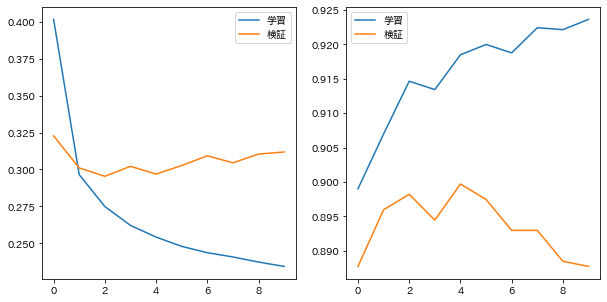

In [39]:
model = Perceptron(300, 4)
task = Task()
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = VerboseTrainer(model, loaders, task, optimizer, 10)
train_predictor = Predictor(model, gen_loader(test_dataset, 1))
valid_predictor = Predictor(model, gen_loader(test_dataset, 1))
trainer.train(train_v, train_t, valid_v, valid_t)

### 76. チェックポイント

問題75から改変してもいいけど，めんどうなので73からやる

In [40]:
import os

In [41]:
class LoggingTrainer(Trainer):
    def save(self, epoch):
        torch.save({'epoch' : epoch, 'optimizer': self.optimizer}, f'result/trainer_states{epoch}.pt')
        torch.save(self.model.state_dict(), f'result/checkpoint{epoch}.pt')
    
    def train(self):
        for epoch in range(self.max_iter):
            train_loss = self.train_epoch()
            valid_loss = self.valid_epoch()
            self.save(epoch)
            print('epoch {}, train_loss:{:.5f}, valid_loss:{:.5f}'.format(epoch, train_loss, valid_loss))

In [42]:
model = Perceptron(300, 4)
task = Task()
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = LoggingTrainer(model, loaders, task, optimizer, 10)
trainer.train()

epoch 0, train_loss:0.40040, valid_loss:0.31460
epoch 1, train_loss:0.29662, valid_loss:0.29968
epoch 2, train_loss:0.27507, valid_loss:0.29352
epoch 3, train_loss:0.26214, valid_loss:0.29494
epoch 4, train_loss:0.25480, valid_loss:0.29803
epoch 5, train_loss:0.24845, valid_loss:0.30234
epoch 6, train_loss:0.24354, valid_loss:0.30566
epoch 7, train_loss:0.24056, valid_loss:0.30266
epoch 8, train_loss:0.23690, valid_loss:0.30744
epoch 9, train_loss:0.23552, valid_loss:0.30812


In [43]:
! ls result/checkpoint*

result/checkpoint0.pt  result/checkpoint4.pt  result/checkpoint8.pt
result/checkpoint1.pt  result/checkpoint5.pt  result/checkpoint9.pt
result/checkpoint2.pt  result/checkpoint6.pt
result/checkpoint3.pt  result/checkpoint7.pt


In [44]:
! ls result/trainer_states*

result/trainer_states0.pt  result/trainer_states4.pt  result/trainer_states8.pt
result/trainer_states1.pt  result/trainer_states5.pt  result/trainer_states9.pt
result/trainer_states2.pt  result/trainer_states6.pt
result/trainer_states3.pt  result/trainer_states7.pt


### 77. ミニバッチ化

In [45]:
from time import time
from contextlib import contextmanager

In [46]:
@contextmanager
def timer(description):
    start = time()
    yield
    print(description, ': {:.3f} 秒'.format(time()-start))

In [47]:
B = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [48]:
task = Task()
for b in B:
    model = Perceptron(300, 4)
    loaders = (
        gen_loader(train_dataset, b, shuffle = True),
        gen_loader(valid_dataset, 1))
    optimizer = optim.SGD(model.parameters(), 0.1 * b)
    trainer = Trainer(model, loaders, task, optimizer, 3)
    with timer(f'バッチサイズ {b}'):
        trainer.train()

epoch 0, train_loss:0.40255, valid_loss:0.31572
epoch 1, train_loss:0.29577, valid_loss:0.29596
epoch 2, train_loss:0.27403, valid_loss:0.29612
バッチサイズ 1 : 33.095 秒
epoch 0, train_loss:0.40084, valid_loss:0.31604
epoch 1, train_loss:0.29652, valid_loss:0.30042
epoch 2, train_loss:0.27489, valid_loss:0.29250
バッチサイズ 2 : 17.824 秒
epoch 0, train_loss:0.40500, valid_loss:0.32660
epoch 1, train_loss:0.29601, valid_loss:0.30258
epoch 2, train_loss:0.27514, valid_loss:0.29598
バッチサイズ 4 : 10.805 秒
epoch 0, train_loss:0.40162, valid_loss:0.31779
epoch 1, train_loss:0.29622, valid_loss:0.30127
epoch 2, train_loss:0.27518, valid_loss:0.29429
バッチサイズ 8 : 7.204 秒
epoch 0, train_loss:0.40383, valid_loss:0.31567
epoch 1, train_loss:0.29712, valid_loss:0.29830
epoch 2, train_loss:0.27537, valid_loss:0.29777
バッチサイズ 16 : 5.286 秒
epoch 0, train_loss:0.40470, valid_loss:0.31348
epoch 1, train_loss:0.29788, valid_loss:0.30318
epoch 2, train_loss:0.27529, valid_loss:0.30294
バッチサイズ 32 : 4.424 秒
epoch 0, train_lo

### 78. GPU上での学習

In [49]:
device = torch.device('cuda')
model = Perceptron(300, 4)
task = Task()
loaders = (
    gen_loader(train_dataset, 128, shuffle = True),
    gen_loader(valid_dataset, 1))
optimizer = optim.SGD(model.parameters(), 0.1 * 128)
trainer = Trainer(model, loaders, task, optimizer, 3, device=device)
with timer('時間'):
    trainer.train()

epoch 0, train_loss:0.42746, valid_loss:0.33626
epoch 1, train_loss:0.30209, valid_loss:0.30645
epoch 2, train_loss:0.27871, valid_loss:0.32206
時間 : 4.240 秒


### 79. 多層ニューラルネットワーク

In [50]:
class ModelNLP79(nn.Module):
    def __init__(self, v_size, h_size, c_size):
        super().__init__()
        self.fc1 = nn.Linear(v_size, h_size)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(h_size, c_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

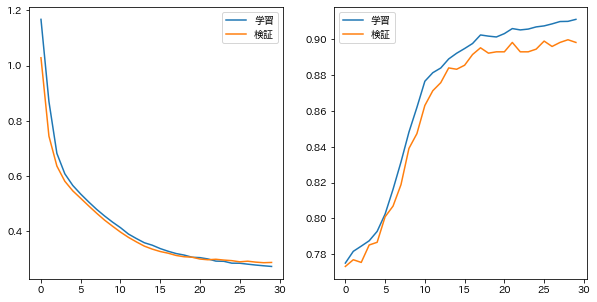

In [51]:
model = ModelNLP79(300, 128, 4)
task = Task()
loaders = (
    gen_loader(train_dataset, 128, shuffle = True),
    gen_loader(valid_dataset, 1))
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = VerboseTrainer(model, loaders, task, optimizer, 30, device)
trainer.train(train_v, train_t, valid_v, valid_t)